C:\Users\rajas\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


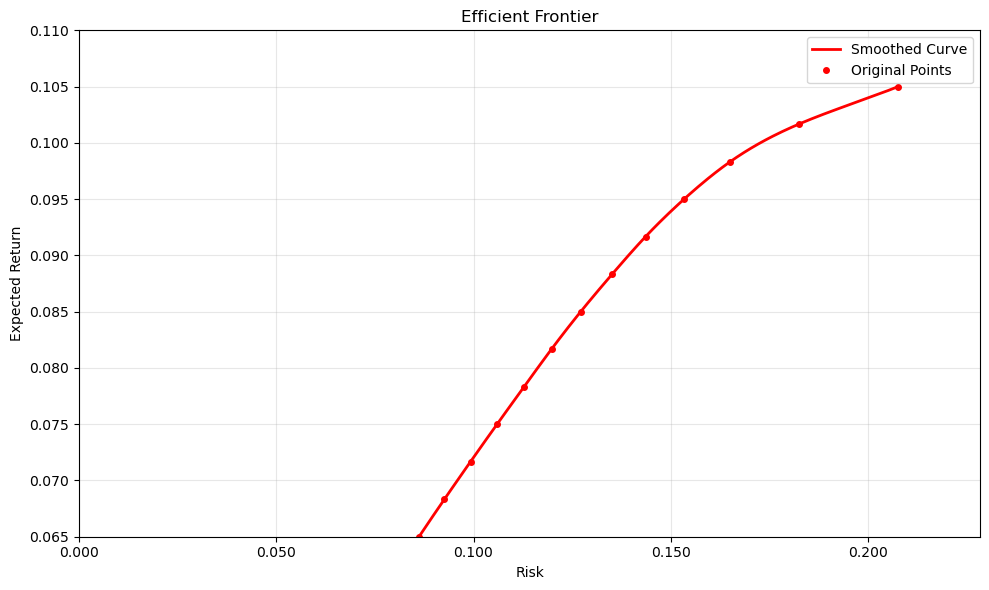


Optimal Portfolio Weights:
US Large Cap Equity: 0.0200
Venture Capital: 0.1113
International Large and Mid Cap Equity (EAFE): 0.0584
Emerging markets equity: 0.0200
Private Equity: 0.0200
Cash: 0.0200
US Fixed Income (investment grade): 0.3140
Hedge Funds (long bias): 0.2306
Infrastructure (Global Core): 0.0200
Private natural resources: 0.1858

Expected Return: 0.0650
Portfolio Risk: 0.0862


In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Asset classes and parameters
asset_classes = [
    "US Large Cap Equity", "Venture Capital", "International Large and Mid Cap Equity (EAFE)",
    "Emerging markets equity", "Private Equity", "Cash", "US Fixed Income (investment grade)",
    "Hedge Funds (long bias)", "Infrastructure (Global Core)", "Private natural resources"
]
expected_returns = np.array([0.07, 0.12, 0.08, 0.10, 0.11, 0.02, 0.03, 0.06, 0.05, 0.09])
volatilities = np.array([0.15, 0.30, 0.18, 0.25, 0.25, 0.01, 0.05, 0.10, 0.12, 0.20])

# Correlation matrix
correlation_matrix = np.array([
    [1.00, 0.30, 0.80, 0.70, 0.60, 0.10, 0.20, 0.60, 0.40, 0.30],
    [0.30, 1.00, 0.20, 0.30, 0.70, 0.00, 0.00, 0.40, 0.20, 0.10],
    [0.80, 0.20, 1.00, 0.80, 0.50, 0.10, 0.30, 0.50, 0.40, 0.30],
    [0.70, 0.30, 0.80, 1.00, 0.60, 0.00, 0.20, 0.50, 0.30, 0.40],
    [0.60, 0.70, 0.50, 0.60, 1.00, 0.00, 0.10, 0.50, 0.40, 0.30],
    [0.10, 0.00, 0.10, 0.00, 0.00, 1.00, 0.50, 0.20, 0.10, 0.00],
    [0.20, 0.00, 0.30, 0.20, 0.10, 0.50, 1.00, 0.30, 0.20, 0.10],
    [0.60, 0.40, 0.50, 0.50, 0.50, 0.20, 0.30, 1.00, 0.40, 0.30],
    [0.40, 0.20, 0.40, 0.30, 0.40, 0.10, 0.20, 0.40, 1.00, 0.30],
    [0.30, 0.10, 0.30, 0.40, 0.30, 0.00, 0.10, 0.30, 0.30, 1.00]
])

covariance_matrix = np.outer(volatilities, volatilities) * correlation_matrix
initial_amount = 1000
num_scenarios = 10000

def calculate_portfolio_risk(weights):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_std

def calculate_portfolio_return(weights):
    return np.sum(weights * expected_returns)

def optimize_portfolio(target_return):
    def objective(weights):
        return calculate_portfolio_risk(weights)
    
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.sum(x * expected_returns) - target_return},
        {'type': 'ineq', 'fun': lambda x: x - 0.02}
    ]
    
    bounds = [(0.02, 0.4) for _ in range(len(asset_classes))]
    initial_weights = np.array([0.1] * len(asset_classes))
    initial_weights = initial_weights / np.sum(initial_weights)
    
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Generate efficient frontier
target_returns = np.linspace(0.065, 0.105, 13)
efficient_portfolios = []
portfolio_risks = []

for target in target_returns:
    weights = optimize_portfolio(target)
    efficient_portfolios.append(weights)
    portfolio_risks.append(calculate_portfolio_risk(weights))

# Convert to numpy arrays
risks = np.array(portfolio_risks)
returns = np.array(target_returns)

# Sort points
sort_idx = np.argsort(risks)
risks = risks[sort_idx]
returns = returns[sort_idx]

# Create smooth curve
x_smooth = np.linspace(risks.min(), risks.max(), 200)
spl = make_interp_spline(risks, returns, k=3)
y_smooth = spl(x_smooth)

# Plot efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, 'r-', label='Smoothed Curve', linewidth=2)
plt.plot(risks, returns, 'ro', label='Original Points', markersize=4)
plt.xlabel('Risk')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().set_facecolor('white')

# Format axis
plt.xlim(0, max(risks) * 1.1)
plt.ylim(0.065, 0.11)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.3f}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.3f}'))

plt.tight_layout()
plt.show()

# Find optimal portfolio
optimal_idx = np.argmax((returns - 0.02) / risks)  # Assuming risk-free rate of 2%
optimal_portfolio = efficient_portfolios[optimal_idx]

print("\nOptimal Portfolio Weights:")
for asset, weight in zip(asset_classes, optimal_portfolio):
    print(f"{asset}: {weight:.4f}")

print(f"\nExpected Return: {returns[optimal_idx]:.4f}")
print(f"Portfolio Risk: {risks[optimal_idx]:.4f}")


In [5]:
def voldec(w, Sigma):
    """
    Compute volatility decomposition
    
    Parameters:
    w (numpy.ndarray): Column vector of portfolio weights
    Sigma (numpy.ndarray): Covariance matrix
    
    Returns:
    numpy.ndarray: Column vector containing volatility decomposition
    """
    w = w.reshape(-1, 1)  # Ensure w is a column vector
    numerator = w * (Sigma @ w)
    denominator = np.sqrt(w.T @ Sigma @ w)
    return numerator.flatten() / denominator
